# POKEDEX SEARCH

In [ ]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import urllib3

urllib3.disable_warnings()

In [ ]:
# Multi page set up
titles = []
for page in range(1, 6):
    url = f"https://scrapeme.live/shop/page/{page}"
    response = requests.get(url, verify=False)
    df = bs(response.content, 'html.parser')

    title = df.find_all("h2", {"class": "woocommerce-loop-product__title"})

    for t in title:
        titles.append(t.get_text())

In [ ]:
# parsing and storing data
# uses name collected to go on specific page and retrieve data
dict = {
    "name": [],
    "price": [],
    "desc": [],
    "stock": [],
    "weight": [],
    "SKU": [],
    "tags": []
}
for t in titles:
    url = f"https://scrapeme.live/shop/{t}"
    resp = requests.get(url, verify=False)
    dr = bs(resp.content, 'html.parser')

    dict["name"].append(t)

    value = dr.find("p", {"class": "price"})
    value = value.text.strip()
    value = value.split("£")[1]
    dict["price"].append(float(value))

    descTag = dr.find("div", {"class": "woocommerce-product-details__short-description"})
    dsc = descTag.get_text(strip=True)
    dict["desc"].append(dsc)

    
    unitTag = dr.find("p", {"class":"stock in-stock"})
    units = unitTag.get_text(strip=True)
    units = units.split(" ")[0]
    dict["stock"].append(int(units))

    weightTag = dr.find("td", {"class" : "product_weight"})
    weight = weightTag.get_text(strip=True)
    weight = weight.split(" ")[0]
    dict["weight"].append(float(weight))


    idTag = dr.find("span",{"class": "sku"})
    id = idTag.get_text(strip=True)
    dict["SKU"].append(id)

    tagList = dr.find("span", {"class": "tagged_as"})
    tag = tagList.get_text()
    tag = tag.replace("\n", "").replace("Tags:", "").strip()
    dict["tags"].append(tag)

In [ ]:
# stores data frame in variable
poke = pd.DataFrame(dict)
poke.to_csv("products.csv", index=False)
poke

In [ ]:
##  correct data types  ##
# type(poke["name"][0]) str
# type(poke["price"][0]) float
# type(poke["desc"][0]) str
# type(poke["stock"][0]) int64
# type(poke["weight"][0]) float64
# type(poke["SKU"][0]) int
# type(poke["tags"][0]) list

In [ ]:
def price_format(value):
    f = float(value)
    formatted = f"{value:06.2f}" 
    return float(formatted)

poke["price"] = poke["price"].map(price_format)

In [ ]:
def sku_format(value):
    formatted = value.zfill(4)
    formatted = int(formatted)
    return formatted

poke["SKU"] = poke["SKU"].map(sku_format)

In [ ]:
def tag_format(value):
    tagArr = value.split(",")
    for t in range(len(tagArr)):
        tagArr[t] = tagArr[t].strip()
    
    return tagArr

poke["tags"] = poke["tags"].map(tag_format)

In [ ]:
# creates discounted price and adds into the csv file
def discounted_price(price):
    discount = float(price) * 0.8
    return discount #float(f"{discount:06.2f}")

poke["discounted_price"] = poke["price"].map(discounted_price)  
#poke["discounted_price"]      

In [ ]:
# collects stats of numerical data given
def average(value):
    metrics = {
        "mean": [],
        "median": [],
        "min": [],
        "max": [],
        "range": []
    }

    mean = round(float(value.mean()),2)
    median = round(float(value.median()),2)
    range = round(float(value.max() - value.min()),2)

    metrics["mean"].append(round(mean,2))
    metrics["min"].append(float(value.max()))
    metrics["max"].append(float(value.min()))
    metrics["median"].append((median))
    metrics["range"].append(range)

    return metrics
    
priceMetrics = average(poke["price"])
weightMetrics = average(poke["weight"])
stockMetrics = average(poke["stock"])

#priceMetrics, weightMetrics, stockMetrics

In [ ]:
poke["price_per_gram"] = poke["price"] / poke["weight"] # £ per kg [£/kg]
poke["stock_unit_cost"] = poke["stock"] / poke["price"] # units per £
poke["desc_length"] = poke["desc"].map(len)

high_value_items = poke[poke["price"] > 190]
#high_value_items
# poke["price_per_gram"]
# poke["stock_unit_cost"]
# poke["desc_length"]


0            NaN
1            NaN
2      85.000000
3      80.000000
4     106.000000
         ...    
75     84.666667
76     86.666667
77    128.666667
78    129.333333
79    156.666667
Name: price_running_avg, Length: 80, dtype: float64

In [ ]:
# advanced feature : finds all occurences of a tag and stores as tally (in alphabetic order)
def tag_freq(tagSeries):
    tagDict = {   }
    
    for tags in tagSeries:
        for tagitem in tags:
            for t in (tags, tagSeries):
                count = [x for x in t if x == tagitem]
                if(count):
                    if tagitem in tagDict:
                        tagDict[tagitem] += 1
                    else:
                        tagDict[tagitem.capitalize()] = 1


    reordered = {}
    for key in sorted(tagDict.keys()):
        reordered[key] = tagDict[key]

    
    return reordered
                    

tagRec = tag_freq(poke["tags"])

# for r in tagRec:
#     if tagRec[r] > 1:
#         print(f"{r}: {tagRec[r]}")


In [ ]:
# advanced feature : categorizes stock, labels them and stores into a new column
def stock_analysis(stockSeries):
    dupe = [    ]

    for stock in stockSeries:
        if stock < 50:
            dupe.append("Low")
        elif stock >= 50 and stock <= 150:
            dupe.append("Medium")
        else:
            dupe.append("High")
    return dupe

poke["stock level"] = stock_analysis(poke["stock"])
#poke["stock level"]

In [ ]:
# advanced feature : using pandas to create new rarity classification based on pricing
poke["rarity"] = pd.cut(
    poke["price"],
    bins=[0, 20, 50, 150, np.inf],
    labels=["Common", "Uncommon", "Rare", "Legendary"]
)
#poke["rarity"]

In [ ]:
####    ADDED FEATURES INCLUDE:    ####
## DISCOUNTED PRICE EXTRACTION
## AVERAGE WEIGHT CALC
## WORD REPEAT ANALYSIS FROM DESCRIPTION
## PRICE BASED RARITY 
## STOCK ANALYSIS 
## PRICE VS WEIGHT VS STOCK VS RARITY PLOTS
## DOUBLE LINE GRAPH

In [ ]:
# THREE GRID PLOT 
price = poke["price"].sort_values()
stock = poke["stock"].sort_values()
weight = poke["weight"].sort_values()

fig, axes = plt.subplots(1, 2, figsize=(20, 6))
axes = axes.flatten()

axes[0].plot(price, stock, color='red',marker = "x")
axes[0].set_xlabel("Price")
axes[0].set_ylabel("Stock")
axes[0].set_title("Stock vs Price")


axes[1].plot(price, weight, color='blue', marker = "o")
axes[1].set_xlabel("Price")
axes[1].set_ylabel("Weight")
axes[1].set_title("Weight vs Price")

plt.tight_layout()
plt.show()


In [ ]:
# Bar Chart
rarity_dict = {
    "common" : [0],
    "uncommon" : [0],
    "rare" : [0],
    "legendary" : [0]
}
for i in poke["rarity"]:
    if i == "Rare":
        rarity_dict["rare"][0] += 1
    elif i == "Legendary":
        rarity_dict["legendary"][0] += 1
    elif i == "Uncommon":
        rarity_dict["uncommon"][0] += 1
    else:
        rarity_dict["common"][0] += 1

for key, value in rarity_dict.items():
    plt.bar(key,int(value[0]))

    plt.title("Basic Bar Chart")
    plt.xlabel("Rarity")
    plt.ylabel("Occourence")
    


In [ ]:
plt.scatter(poke["price_per_gram"], poke["stock"], color='purple')
plt.xlabel("Price per gram")
plt.ylabel("Stock")
plt.title("Stock vs Price per gram")
plt.show()

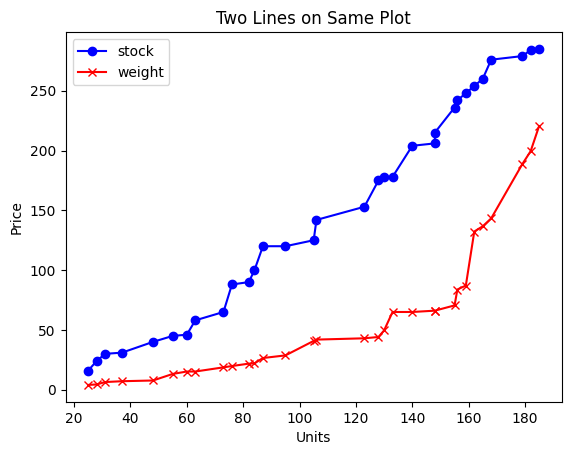